In [54]:
%%bash

source /root/.local/share/jupyter/kernels/face_emo_cnn/bin/activate

pip install matplotlib
pip install pydot
pip install graphviz

In [2]:
!pwd
!ls ../

/tf/notebooks/face_emotion/face_classification_modi/src
Dockerfile  README.md	      datasets	report.pdf  trained_models
LICENSE     REQUIREMENTS.txt  images	src


In [1]:
import sys

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input
import matplotlib.pyplot as plt

# parameters for loading data and images
image_path = '../images/test_image.jpg'
# detection_model_path = '../trained_models/detection_models/haarcascade_frontalface_default.xml'
detection_model_path = '../trained_models/detection_models/haarcascade_frontalface_alt2.xml'
emotion_model_path = '../trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'
gender_model_path = '../trained_models/gender_models/simple_CNN.81-0.96.hdf5'
emotion_labels = get_labels('fer2013')
gender_labels = get_labels('imdb')
font = cv2.FONT_HERSHEY_SIMPLEX

Using TensorFlow backend.


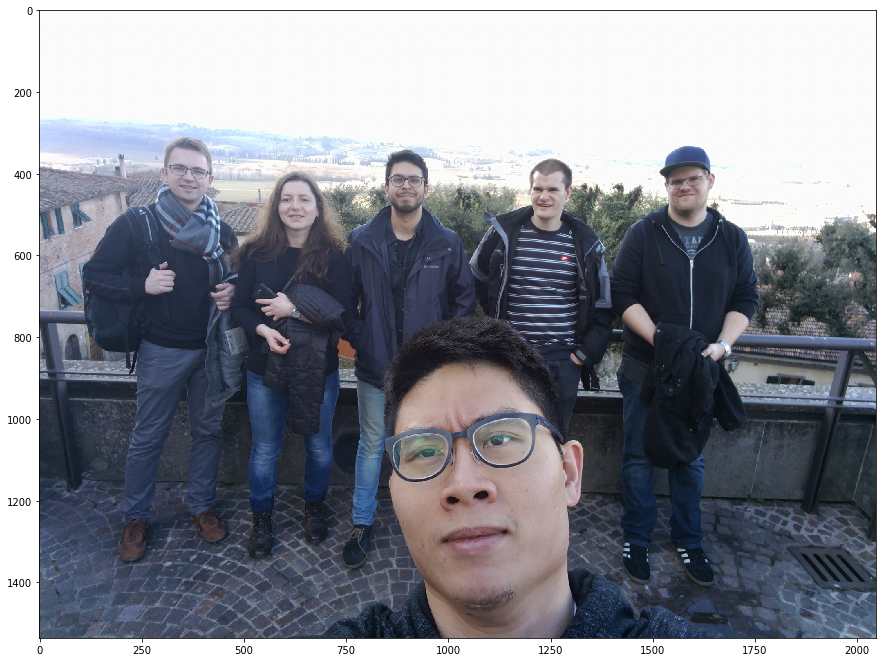

In [18]:
# 입력 이미지
fig = plt.figure(figsize=(15, 15))
plt.imshow(plt.imread('../images/test_image.jpg'))

In [2]:
# hyper-parameters for bounding boxes shape
gender_offsets = (30, 60)
gender_offsets = (10, 10)
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
gender_classifier = load_model(gender_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]
gender_target_size = gender_classifier.input_shape[1:3]

# loading images
rgb_image = load_image(image_path, grayscale=False)
gray_image = load_image(image_path, grayscale=True)
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')

faces = detect_faces(face_detection, gray_image)
for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, gender_offsets)
    rgb_face = rgb_image[y1:y2, x1:x2]

    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]

    try:
        rgb_face = cv2.resize(rgb_face, (gender_target_size))
        gray_face = cv2.resize(gray_face, (emotion_target_size))
    except:
        continue

    rgb_face = preprocess_input(rgb_face, False)
    rgb_face = np.expand_dims(rgb_face, 0)
    gender_prediction = gender_classifier.predict(rgb_face)
    gender_label_arg = np.argmax(gender_prediction)
    gender_text = gender_labels[gender_label_arg]

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    emotion_text = emotion_labels[emotion_label_arg]

    if gender_text == gender_labels[0]:
        color = (0, 0, 255)
    else:
        color = (255, 0, 0)

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, gender_text, color, 0, -20, 1, 2)
    draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -50, 1, 2)

bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
# plt.imshow(bgr_image)
cv2.imwrite('../images/predicted_test_image_haar_diff.png', bgr_image)

<CascadeClassifier 0x7ff4919df590>


True

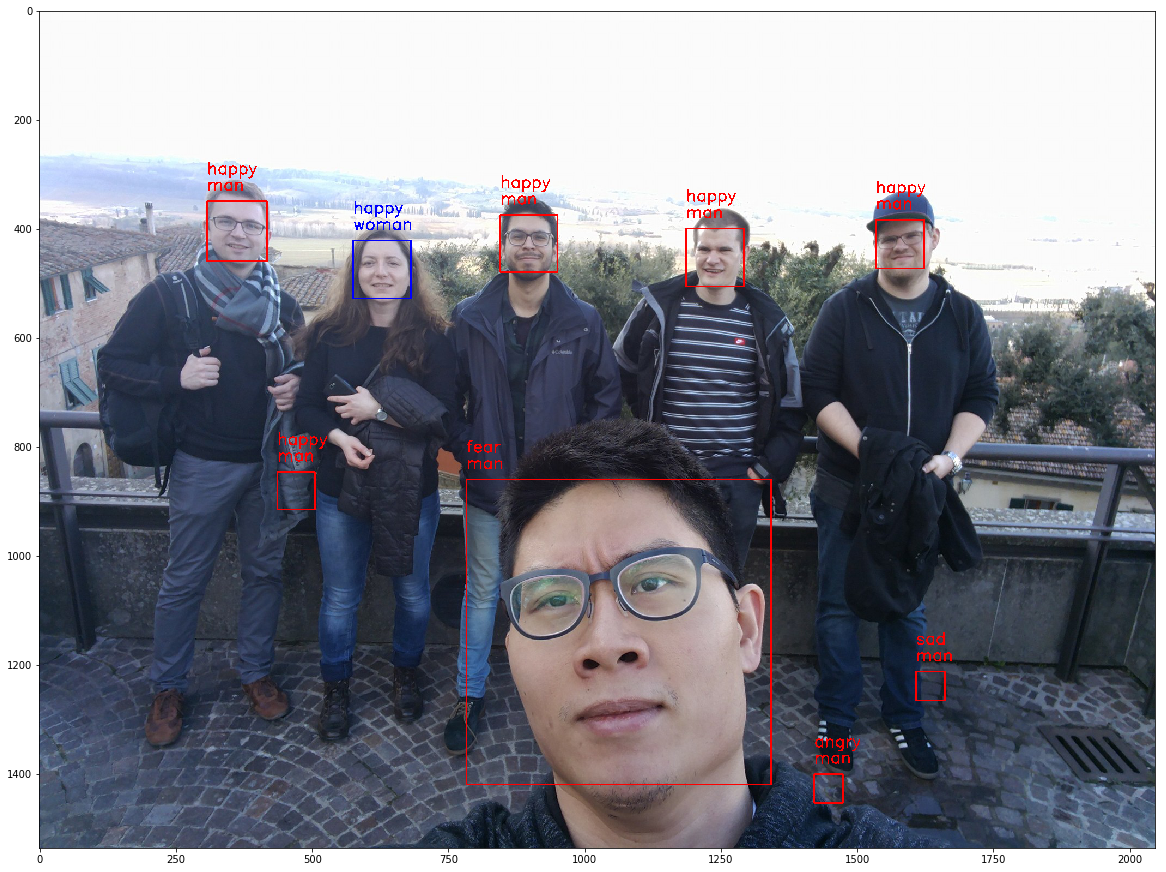

In [16]:
# default haar
img = plt.imread('../images/predicted_test_image.png')
fig = plt.figure(figsize=(20, 20))
plt.imshow(img)

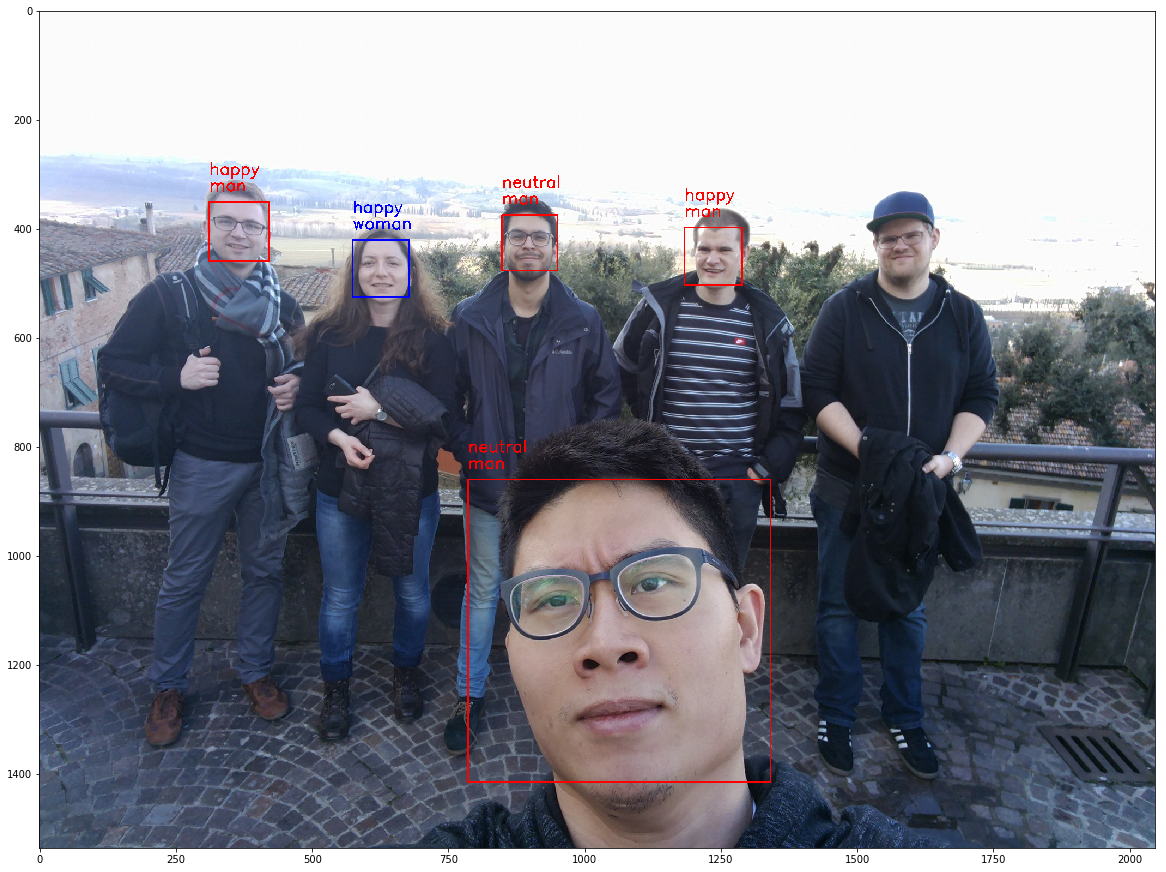

In [35]:
img = plt.imread('../images/predicted_test_image_haar_diff.png')
fig = plt.figure(figsize=(20, 20))
plt.imshow(img)

## Model 설명

    1. face detection
    2. emotion detection
    3. gender detection

### 1. face detection
    OpenCV Haar cascade 방식
    예시 설명: http://blog.naver.com/PostView.nhn?blogId=ocllos&logNo=194366766
    상세 설명: https://darkpgmr.tistory.com/70

### 2. emotion detection
    Keras fer2013_mini_XCEPTION.102-0.66.hdf5 모델
    학습데이터: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
        48 x 48 gray scale image 3만여개
        7 Category  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


In [19]:
import pandas as pd
data_csv = pd.read_csv('/tf/notebooks/face_emotion/face_classification_modi/datasets/fer2013/fer2013.csv')

In [20]:
data_csv.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Usage
PrivateTest     3589
PublicTest      3589
Training       28709
Name: Usage, dtype: int64

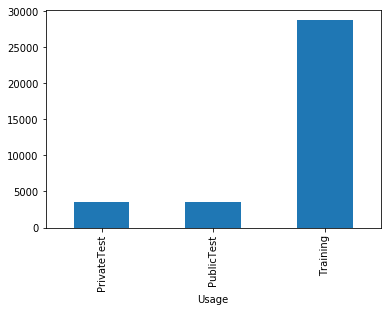

In [27]:
data_csv['Usage'].groupby(data_csv['Usage']).count().plot(kind='bar')
data_csv['Usage'].groupby(data_csv['Usage']).count()

In [42]:
48*48

2304

In [46]:
sample_pixel = data_csv.loc[0].pixels.split(" ")
len(sample_pixel)

2304

Real-time face detection and emotion/gender classification using fer2013/IMDB datasets with a keras CNN model and openCV.

    IMDB gender classification test accuracy: 96%.
    fer2013 emotion classification test accuracy: 66%.

In [48]:
emotion_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 62, 62, 8)     72          input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 62, 62, 8)     32          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 62, 62, 8)     0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [4]:
import keras
keras.utils.plot_model(emotion_classifier, to_file='fer2013_mini_XCEPTION.102-0.66.model.png', show_shapes=True, show_layer_names=True)

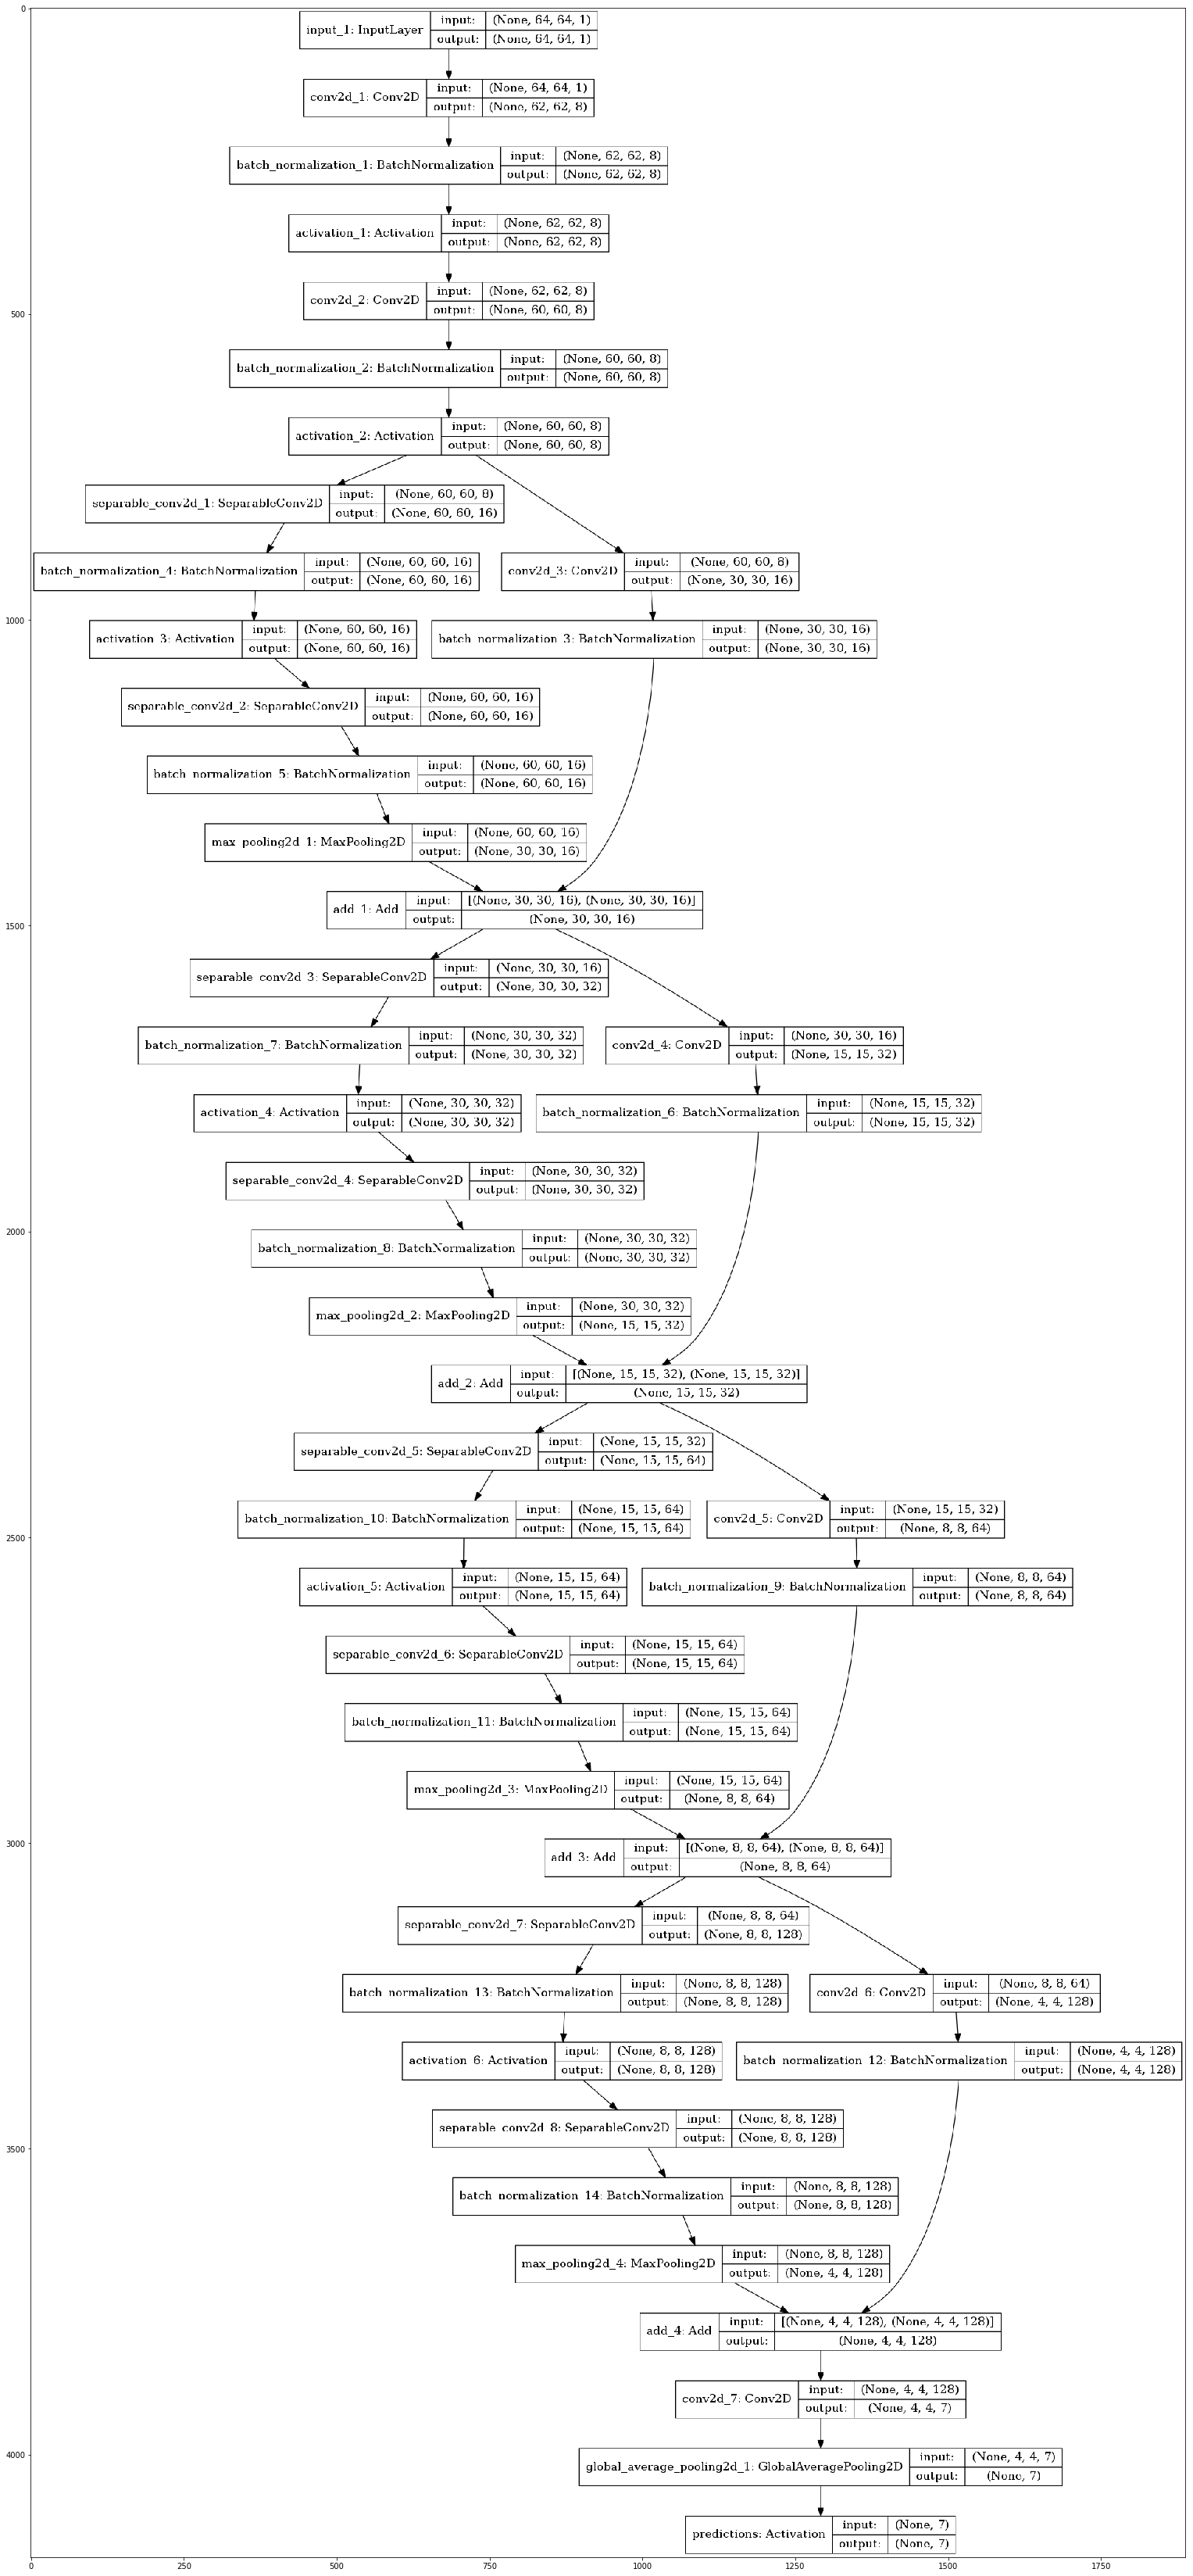

In [11]:
fig = plt.figure(figsize=(60, 60))
plt.imshow(plt.imread('fer2013_mini_XCEPTION.102-0.66.model.png'))

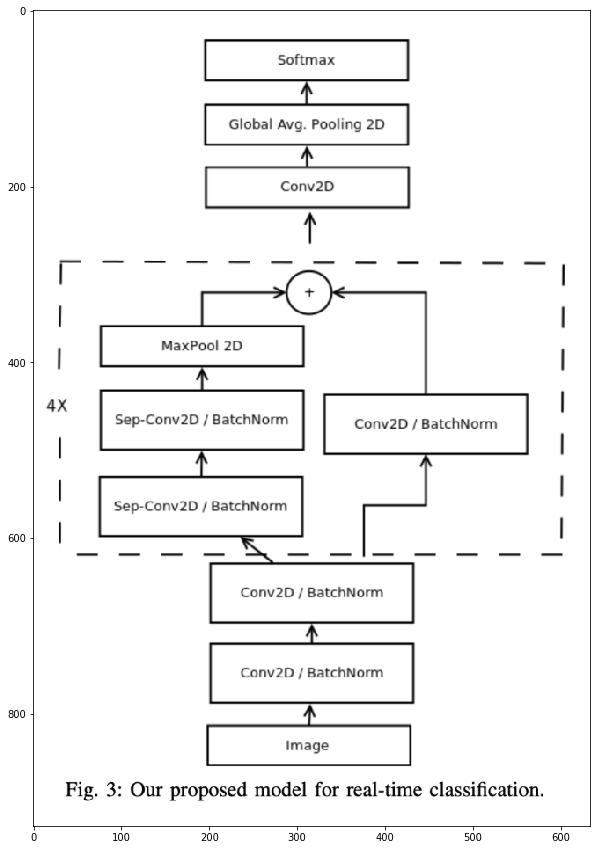

In [18]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(plt.imread('/tf/notebooks/face_emotion/face_classification_modi/images/simple_model_structure.png'))

* Activation Function: Relu
* Optimizer: 
    * Adam default(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    * ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
    * EarlyStopping('val_loss', patience=50)
* batch size: 32
* epochs: 10000
* loss: categorical_crossentropy

### References
* Separable Conv2D: 
    * 상세설명: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
    * xception설명: http://openresearch.ai/t/xception-deep-learning-with-depthwise-separable-convolutions/49